<br>
<br>
<h2>Purpose</h2>
<br>
<hr>
A notebook to develop an AI system aiming at trading intraday on cryptocurrencies
<br>
<br>

<br>
<br>
<h2>Imports</h2>
<br>
<hr>
<br>

In [3]:
# Pandas and Python
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import time

# Graphic Libraries
import plotly.io as pio
pio.templates.default = "simple_white"
pio.renderers.default = "notebook"
import matplotlib.pyplot as plt
from IPython.display import clear_output

# AI and stats
import statsmodels.api as sm
import xgboost
from xgboost import XGBRegressor
import sklearn

# Multiprocessing
from functools import partial
from multiprocessing import Pool
from threadpoolctl import threadpool_limits



<br>
<br>
<h2>Notebook Parameters</h2>
<br>
<hr>
<br>

In [1]:
# Define data path
data_path = "in_sample/"

# Risk free rate assumption
risk_free_rate = 0.05 # % per year
rfr_hourly = (1 + risk_free_rate)**(1 / (24*365)) - 1

# Suggested training set
start_date_train = "2023-01-24"
last_date_train = "2024-01-24"

# Suggested validation set
start_date_validate = "2024-01-25"
last_date_validate = "2024-07-24"

# Test set (Unavailable)
# start_date_test = "2024-07-25"
# last_date_test = "2025-01-24"

# Maximum number of features to use
max_nb_features = 40

# Random seed for feature selection
random_seed = 0

# Set a level of transaction costs
tc = 0.0000

# Set the percentage of engineered features to use
pct_engineered_features = 0.25


<br>
<br>
<h2>Data Loading</h2>
<br>
<hr>
<br>

In [7]:
# Main data
data = pd.read_csv(
    f"{data_path}data_in_sample.csv",
    index_col=0,
    header=[0,1],
)

# Make sure that the index is in the right format
data.index = pd.to_datetime(data.index)


<h4>Features</h4>
Continue to use a simple first batch of features
<br>

In [8]:
simple_features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

# Iterate over some interesting fields to create features
for field in [
    "return",
    "close",
    "nb_trades",
    "volume_usd",
    "funding_rate",
    "open_interest_value"
]:
    print(f"Make features using raw field {field}")

    # Extract raw data
    raw_data = data[field]

    # Create raw feature
    for feature_style in [
        "level",
        "delta_1",
        "delta_6",
        "shift_1",
        "shift_3",
        "shift_6",
        "shift_24",
        "mean_6",
        "mean_24",
        "mean_120",
        "std_6",
        "std_24",
        "std_120",
        "skew_6",
        "skew_24",
        "skew_120",
        "kurt_6",
        "kurt_24",
        "kurt_120",
    ]:

        # Level
        if feature_style == "level":
            raw_feature = raw_data

        # Delta 1
        if feature_style == "delta_1":
            raw_feature = raw_data.pct_change(1, fill_method=None)

        # Delta 6
        if feature_style == "delta_6":
            raw_feature = raw_data.pct_change(6, fill_method=None)

        # Shift 1
        if feature_style == "shift_1":
            raw_feature = raw_data.shift(1)

        # Shift 3
        if feature_style == "shift_3":
            raw_feature = raw_data.shift(3)

        # Shift 6
        if feature_style == "shift_6":
            raw_feature = raw_data.shift(6)

        # Shift 24
        if feature_style == "shift_24":
            raw_feature = raw_data.shift(24)

        # Mean 6
        if feature_style == "mean_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,1).mean()

        # Mean 24
        if feature_style == "mean_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,1).mean()

        # Mean 120
        if feature_style == "mean_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,1).mean()

        # Std 6
        if feature_style == "std_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,2).std()

        # Std 24
        if feature_style == "std_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,2).std()

        # Std 120
        if feature_style == "std_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,2).std()

        # Skew 6
        if feature_style == "skew_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,3).skew()

        # Skew 24
        if feature_style == "skew_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,3).skew()

        # Skew 120
        if feature_style == "skew_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,3).skew()

        # Kurtosis 6
        if feature_style == "kurt_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,4).kurt()

        # Kurtosis 24
        if feature_style == "kurt_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,4).kurt()

        # Kurtosis 120
        if feature_style == "kurt_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,4).kurt()


        # Stack and store feature
        raw_feature = raw_feature.stack().reindex(simple_features.index)
        simple_features[f"{field}_{feature_style}"] = raw_feature



Make features using raw field return
Make features using raw field close
Make features using raw field nb_trades
Make features using raw field volume_usd
Make features using raw field funding_rate
Make features using raw field open_interest_value


<br>
Also use a certain percentage of engineered features
<br>
<br>

In [9]:
# Load engineered features
engineered_features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

for dirpath, dirnames, filenames in os.walk(data_path):

    # Only keep standard features for the moment
    filenames = [i for i in filenames if "feature" in i]

    # Select a random list of features (always the same)
    np.random.seed(random_seed)
    subset_filenames = np.random.choice(
        a=filenames,
        size=min(int(max_nb_features*pct_engineered_features), len(filenames)),
        replace=False,
    )
    for filename in subset_filenames:

        print(f"Loading {filename}")

        # Load feature
        feature = pd.read_csv(
            f"{data_path}{filename}",
            index_col=0,
            header=[0],
        )

        # Make sure that the index is in the right format
        feature.index = pd.to_datetime(feature.index)

        # Store in the feature dict
        engineered_features[filename.replace(".csv", "")] = feature.stack().reindex(
            engineered_features.index)


Loading feature_576016642244.csv
Loading feature_479883256457.csv
Loading feature_349700183501.csv
Loading feature_004212234751.csv
Loading feature_811799367203.csv
Loading feature_902830881058.csv
Loading feature_447214984470.csv
Loading feature_232377146700.csv
Loading feature_025508110388.csv
Loading feature_329046432311.csv


<br>
Putting all features together
<br>
<br>

In [10]:
# Aggregate engineered and simple features all together
features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

# Select a random list of simple features (always the same)
np.random.seed(random_seed)
subset_simple_features = np.random.choice(
    a=list(simple_features.keys()),
    size=min(int(max_nb_features*(1-pct_engineered_features)),
             len(simple_features.keys())),
    replace=False,
)

for feature_name in subset_simple_features:

    features[feature_name] = simple_features[feature_name]

for feature_name in engineered_features:

    features[feature_name] = engineered_features[feature_name]



In [ ]:
print(f"Total features: {len(features.columns)}")

<br>
<br>
<h2>Analytics</h2>
<br>
<hr>
Basic Portfolio analytics to invest in some predictions of the future instruments returns
<br>
<br>


In [11]:
def expected_returns_to_positions(expected_returns):
    """
    Normalize expected returns to make it an investable portfolio

    :param expected_returns: pd.DataFrame containing expectations
                             about future instruments prices variations
    """

    # Positions will be proportional to ranked alpha
    positions = expected_returns.rank(axis=1)

    # Re-scale the leverage
    positions = positions.div(positions.abs().sum(axis=1), axis=0)

    # Make the portfolio dollar neutral
    positions = positions.sub(positions.mean(axis=1), axis=0)

    return positions


def get_sharpe(pnl_portfolio, rfr_hourly):
    """
    Compute the sharpe ratio

    :param pnl_portfolio: pd.Series of returns of the portfolio considered
    :param rfr_hourly: float, the hourly risk free rate
    """

    # Compute excess returns
    excess_returns = pnl_portfolio - rfr_hourly

    # Compute sharpe ratio
    sharpe_ratio = (
        excess_returns.mean() / excess_returns.std() * np.sqrt(24 * 365)
    )

    # Output
    return round(sharpe_ratio, 2)


def pnl_analytics(positions,
                  returns,
                  rfr_hourly,
                  lag,
                  tc=0):
    """
    Compute the p&l analytics of the strategy

    :param positions: pd.DataFrame, some positions that have been reached
    :param returns: pd.DataFrame containing returns of instruments
    :param rfr_hourly: float, the hourly risk free rate
    :param lag: int, the number of hours to reach the positions
    :param tc: float, the transaction costs

    """

    # Compute gross p&l
    pnl = positions.shift(1+lag).mul(returns).sum(axis=1)

    # Compute transaction costs
    trades = positions.fillna(0).diff()
    costs = trades.abs().sum(axis=1) * tc

    # Net p&l: deduce costs from gross p&l
    pnl = pnl.sub(costs, fill_value=0)

    # Compute sharpe
    sharpe = get_sharpe(pnl, rfr_hourly)

    return {"sharpe": sharpe,
           "pnl": pnl}


def analyze_expected_returns(
    expected_returns,
    returns,
    rfr_hourly,
    title = "a Nice Try",
    lags = [0,1,2,3,6,12],
    tc = 0,
    plot_option="matplotlib",
    output_stats=False,
):
    """
    Provide an economic analysis of some expected_returns

    :param expected_returns: pd.DataFrame containing expectations
                             about future instruments prices variations
    :param returns: pd.DataFrame containing returns of instruments
    :param rfr_hourly: float, the hourly risk free rate
    :param lags: list of int, corresponding to the number of hours to
                 reach the positions
    :param tc: float, the transaction costs
    :param plot_option: str, the library used to display the cumulative
                        p&l plot, can be "plotly" or "matplotlib"
    :param output_stats: boolean, wheter or not to output basic portfolio
                         statistics
    """

    # Take positions as a function of expected returns
    positions = expected_returns_to_positions(expected_returns)

    # Compute p&l and sharpe for different lags
    pnl_lags = {}
    for lag in lags:
        analytics_lag = pnl_analytics(
            positions=positions,
            returns=returns,
            rfr_hourly=rfr_hourly,
            lag=lag,
            tc=tc)
        lag_label = f"Lag {lag}, sharpe={analytics_lag['sharpe']}"
        pnl_lags[lag_label] = analytics_lag["pnl"]

    # Compute cumulative returns
    pnl_lags = pd.concat(pnl_lags, axis=1).dropna()
    cumulative_pnl_lags = (1+pnl_lags).cumprod().resample("24h").last()

    # Display
    if plot_option == "plotly":

        pd.options.plotting.backend = "plotly"

        fig = cumulative_pnl_lags.plot(
            title=f"Cumulative returns of {title}",
        )
        fig.update_layout(yaxis_type="log")
        fig.show()

    elif plot_option == "matplotlib":

        pd.options.plotting.backend = "matplotlib"

        ax = cumulative_pnl_lags.plot(
            title=f"Cumulative returns of {title}",
            logy=True,
            grid=False,
            figsize=(10, 4),
        )
        plt.show()

    else:
        raise ValueError("plot_option must be either 'plotly' or 'matplotlib'")

    # Output statistics if requested
    if output_stats:

        statistics = {}

        # Compute turnover
        turnover = positions.fillna(0).diff().abs().sum(axis=1).mean()
        statistics["turnover"] = round(turnover * 24, 2) # standardize the turnover to be daily

        # Compute sharpe
        statistics["sharpe"] = pnl_analytics(
            positions=positions,
            returns=returns,
            rfr_hourly=rfr_hourly,
            lag=lags[0],
            tc=tc,
        )["sharpe"]

        return pd.Series(statistics).to_frame("Statistics").T



<br>
<br>
<h2>Features Standard Pre-Processing</h2>
<br>
<hr>

<br>


In [12]:
label = data["return"].loc[start_date_train:last_date_train
    ].shift(-1).stack()

In [13]:
features_normalized = pd.DataFrame().reindex_like(features)

for feature_name in features.keys():

    print(f"Pre-processing {feature_name}")

    # Extract the feature
    feature_normalized = features[feature_name].unstack()

    # Rank the feature to remove outliers
    feature_normalized = feature_normalized.rank(axis=1, pct=True) - 0.5

    # Stack the feature
    feature_normalized = feature_normalized.stack().reindex(
        features_normalized.index
    )

    # Store this normalized version
    features_normalized[feature_name] = feature_normalized

# Replace NaNs by average values, as OLS cannot handle NaNs effectively
features_normalized = features_normalized.fillna(0)

# Only keep datetimes that are common between the label and the features
# for training
common_index = label.index.intersection(features_normalized.index)
features_normalized_train = features_normalized.reindex(common_index)
label = label.reindex(common_index)


Pre-processing close_skew_24
Pre-processing return_std_6
Pre-processing funding_rate_skew_24
Pre-processing return_mean_6
Pre-processing close_shift_6
Pre-processing volume_usd_kurt_6
Pre-processing open_interest_value_kurt_120
Pre-processing close_shift_1
Pre-processing funding_rate_kurt_120
Pre-processing return_delta_6
Pre-processing nb_trades_std_6
Pre-processing funding_rate_skew_6
Pre-processing nb_trades_skew_6
Pre-processing volume_usd_skew_24
Pre-processing open_interest_value_std_6
Pre-processing funding_rate_kurt_24
Pre-processing volume_usd_delta_6
Pre-processing volume_usd_mean_120
Pre-processing return_kurt_6
Pre-processing return_skew_6
Pre-processing volume_usd_std_24
Pre-processing open_interest_value_std_24
Pre-processing close_mean_6
Pre-processing nb_trades_std_120
Pre-processing funding_rate_shift_24
Pre-processing return_mean_24
Pre-processing close_std_24
Pre-processing open_interest_value_mean_6
Pre-processing funding_rate_skew_120
Pre-processing return_shift_1


<br>
<br>
<h2>XGBoost: Gradient Boosted Decision Trees</h2>
<br>
<hr>
Gradient Boosted Decision Trees are another way to introduce non-linearity in our model. This non-linearity is present in the link between the label and features, but also among the features themselves. Overfitting is limited thanks to a variety of strategies, resulting in potentially better generalization.
<br>
<br>


<br>
<h4>Defining hyper-parameters</h4>
<br>



In [15]:
# Define hyperparameters
hyperparameters = {
    "learning_rate": 0.001,
    "n_estimators": 500,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "base_score": 0,
    "max_depth": 7,
    "min_child_weight": 10,
    "subsample": 0.05,
    "colsample_bytree": 0.3,
    "min_split_loss": 0,
    "reg_lambda": 1,
    "reg_alpha": 0,
    "n_jobs": 1,
    "random_state": 0,
}

<br>
<h4>Training the models</h4>
<br>



Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00

Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

Train a model from date 2022-09-05 00:00:00 to date 2023-08-31 00:00:00
Predict from date 2023-08-31 01:00:00 to date 2023-10-01 00:00:00

Train a model from date 2022-10-05 00:00:00 to date 2023-09-30 00:00:00
Predict from date 2023-09-30 01:00:00 to date 2023-10-31 00:00:00

Train a model from date 202

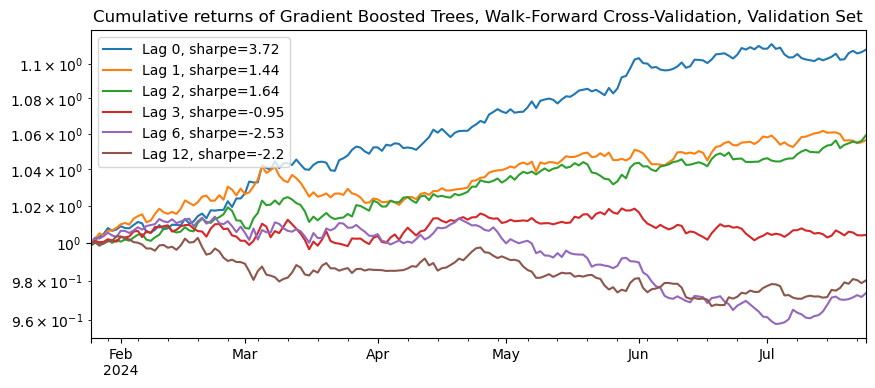

In [17]:
# Measure time
t1 = time.time()

# Recompute the model every month, skip the first 2 months
rebalancing_dates = pd.date_range(
    start=start_date_train,
    end=last_date_validate,
    freq="ME"
)[2:]

def train_predict_period(
    last_date_train_fold,
    returns,
    hyperparameters,
):

    # Force the usage of a single core inside of the function,
    # to avoid nested multiprocessing attempts
    with threadpool_limits(limits=1):

        # Define training and validation dates

        # Train the model over the last X months
        start_date_train_fold = last_date_train_fold - pd.Timedelta(days = 30 * 12)

        # The model cannot be used before the first hour following the training
        # (no look-forward bias)
        start_date_validate_fold = last_date_train_fold + pd.Timedelta(hours = 1)

        # The trained model will be used for 1 month
        last_date_validate_fold = last_date_train_fold + pd.Timedelta(days = 31 * 1)

        # Log informations
        print(f"Train a model from date {start_date_train_fold} to date {last_date_train_fold}")
        print(f"Predict from date {start_date_validate_fold} to date {last_date_validate_fold}")
        print("")


        # Create label
        label_fold = returns.loc[start_date_train_fold:last_date_train_fold
            ].shift(-1).stack()

        # Only keep dates of the train and validation sets for the features
        features_normalized_train_fold = features_normalized.reindex(label_fold.index)
        features_normalized_validate_fold = features_normalized.sort_index().loc[
            start_date_validate_fold:last_date_validate_fold]

        # Split the data along the time axis
        ts_splitter = sklearn.model_selection.TimeSeriesSplit(n_splits=5)

        # Create model
        model = XGBRegressor(**hyperparameters)

        # Fit model
        model = model.fit(
            y=label_fold,
            X=features_normalized_train_fold,
        )

        # Predict on the validation set
        predictions = model.predict(
            features_normalized_validate_fold)
        predictions = pd.Series(
            predictions,
            index=features_normalized_validate_fold.index
        ).unstack()

        # Output results
        return pd.concat(
            {str(last_date_train_fold) : predictions},
            axis=1
        )

# Fix all but one function parameters to iterate on the last one
partial_train_predict_period = partial(
    train_predict_period,
    returns=data["return"],
    hyperparameters=hyperparameters,
)

# Train using one core per date
predictions = []
for date in rebalancing_dates:
    pred = train_predict_period(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters  # or model parameters
    )
    predictions.append(pred)

# Reformat predictions
predictions = pd.concat(predictions, axis=1).T.groupby(level=1).sum().T

# Remove extra zeros added in the process, as we don't want to take positions
# if there was no prediction
predictions = predictions.replace(0, np.nan)

# Remove empty and invalid dates
predictions = predictions.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"Total Training time is {t2-t1} seconds")

# Analyse our predictions
analyze_expected_returns(
    expected_returns=predictions.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"Gradient Boosted Trees, Walk-Forward Cross-Validation, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,

)